# ULTIMO tutorial 2: Set connectors for the road network

Connectors are the nodes in the network where traffic from the TAZ enters or leaves the network, i.e. the start and end points of trips. In this tutorial, the connectors are set based on population density. Therefore, a GeoDataFrame containing points with population on a 1km grid is used, based on [GHSL](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop). The population will then be sorted into clusters depending on the size of the individual TAZs, and the centroids for these clusters will be determined. In order to form a connection to the network, the centroids will be moved to the nearest network node. Duplicates will be removed.

The inputs are:
- Road network with edges and nodes (see tutorial1)
- TAZ as GeoDataFrame
- Population density as point GeoDataFrame

## Import packages

In [2]:
# for network creation
import network.CreateNetwork as CreateNetwork

In [3]:
# for reading and saving files etc.
import geopandas as gpd
import pandas as pd
# for time tracking
from datetime import datetime

## Read input: TAZ and population

The input includes georeferenced TAZ in `EPSG:4326` with the following _required_ attributes (columns):

* __ID__ | field including a unique ID, e.g. the NUTS ID
* __Country__ | field containing the ISO-2 code of the respective country

Other attributes like name, population etc. can be added, but are not required for the following steps.

Population currently needs to be provided in the form of a point `GeoDataFrame`.

In [6]:
# load taz from database or local
taz = gpd.GeoDataFrame.from_file('tutorial-files/_input/taz-tutorial.gpkg')

# defining ID, country and geometry column names of taz
taz_id = "nuts_id"
taz_cn = "cntr_code"
taz_geo = "geometry"

taz.head()

,nuts_id,cntr_code,nuts_name,geometry
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63..."
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62..."
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62..."
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61..."
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62..."


In [7]:
countries = taz[taz_cn].unique()

In [8]:
# read population
pop = gpd.GeoDataFrame.from_file('tutorial-files/_input/4326-points-population.gpkg')

## Define connectors

For each TAZ in the `taz GeoDataFrame`, the population centers are determined and moved to the nearest network node.

In [9]:
# create population centroids for TAZ
print("Start identifying connectors: {}".format(datetime.now()))
conn_ = CreateNetwork.Connectors()
conn_.find_connector_locations(taz, pop, taz_geom='geometry')
print("Population centroids created: {}".format(datetime.now()))

Start identifying connectors: 2023-03-14 15:24:10.402302
Population centroids created: 2023-03-14 15:35:43.702641


In [10]:
# clean up: delete pop, as it takes up a lot of memory
del pop

Move to network nodes: read all nodes first and combine to single GDF; then find nearest node to population centers __within__ the same country

In [12]:
path_export = 'tutorial-files/tutorial2/'
path_import = 'tutorial-files/tutorial1/'

In [ ]:
# combine all network nodes of the region
for i,cn in enumerate(countries):
    # get nodes
    print(cn)
    nodes = gpd.GeoDataFrame.from_file(path_import +'{}_n'.format(cn)+'.gpkg')
    # add country attribute to nodes (ensure that connector nodes are found within the same country)
    nodes['cntr_code'] = cn
    if i == 0:
        nodes_all=nodes
    else:
        nodes_all = pd.concat([nodes_all, nodes])

In [13]:
print("Move to road network nodes: {}".format(datetime.now()))
# Move population centroids to network nodes
all_conn = conn_.identify_connector_nodes(nodes=nodes_all, zone=taz_id, weight="weight", country_check='cntr_code')
# save to file
all_conn.to_file(path_export + "connectors" + ".gpkg", driver="GPKG")
print("Connectors created: {}".format(datetime.now()))

Move to road network nodes: 2023-03-14 15:47:57.891261
FI
DK
SE
NO
Duplicates detected!
4 0.24064906824924184
69.0
Move 10 connectors from foreign nodes...
Connectors created: 2023-03-14 15:48:00.387823


## Result after tutorial2

<AxesSubplot:>

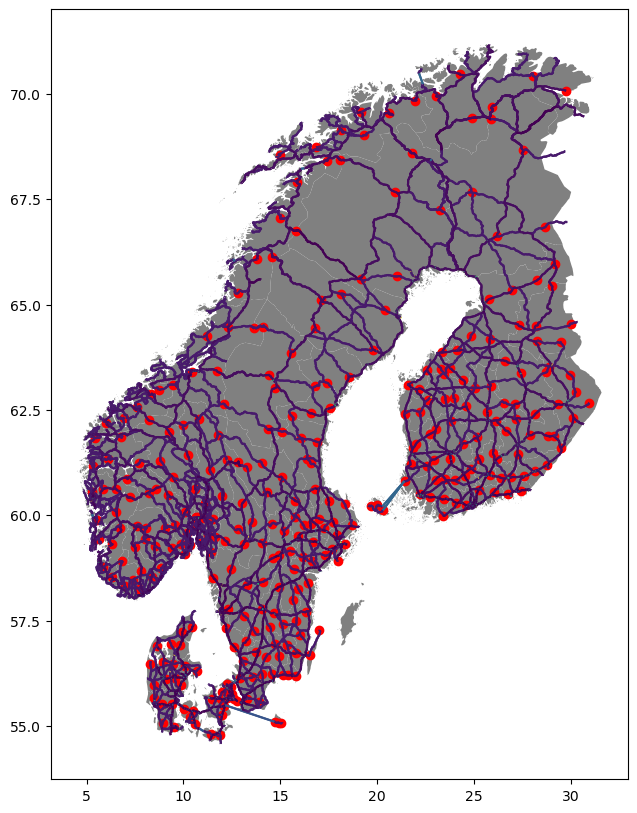

In [14]:
# plot taz, network and connectors
# read networks
for i,cn in enumerate(countries):
    # get roads
    net = gpd.GeoDataFrame.from_file(path_export +'{}_e'.format(cn)+'.gpkg')
    net.crs=4326
    if i == 0:
        net_all=net.copy()
    else:
        net_all = pd.concat([net_all, net])
    del net
# plot
ax=taz[taz_geo].plot(color="grey", figsize=(20,10))
net_all.plot(ax=ax, column='type', kind='geo')
all_conn.plot(ax=ax, kind='geo', color='red')